In [1]:
library("readxl")

library(GenomicRanges)
library(GenomicFeatures)

library(biomaRt)
library(AnnotationHub)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(BSgenome.Hsapiens.UCSC.hg38)
library(BSgenome.Hsapiens.UCSC.hg19)
library("org.Hs.eg.db")


library(enrichR)
library(annotatr)
library(regioneR)
library(plyranges)
library(rtracklayer)

library(Gviz)
library(ggbio)
library(genomation)
library(karyoploteR)

library(tidyr)
library(dplyr)
library(plotly)
library(ggplot2)
library(flipPlots)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The follow

In [241]:
ah <- AnnotationHub()

snapshotDate(): 2021-05-18



In [249]:
grs <- query(ah, "GRanges")
grs <- ah[ah$rdataclass == "GRanges",]
grs <- grs[grs$species == "Homo sapiens",]

In [312]:
meta_df <- mcols(grs)
# meta_df <- meta_df[meta_df$genome == 'hg38',]

# Import Data

## Mappability bed file

The mappability bed file specifies the regions where the sequencing strategy can detect cleavage events.

In [3]:
map_bed <- toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/mappability.stranded.hg38.bed',
                                sep='\t'))

In [142]:
map_bed_chr19 <- map_bed[map_bed@seqnames == 'chr19']

## Consensus

In [2]:
consensus_bed <- toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/consensus_footprints_and_collapsed_motifs_hg38.bed',
                                sep='\t'))

In [3]:
consensus_bed_ctcf <- consensus_bed[grep('CTCF', consensus_bed$V12),]

In [4]:
nrow(toDataframe(consensus_bed_ctcf))

[1] 211643

In [5]:
annots = c('hg38_cpgs', 'hg38_basicgenes', 
           'hg38_genes_intergenic',
           'hg38_genes_intronexonboundaries')

# Build the annotations (a single GRanges object)
annotations = build_annotations(genome = 'hg38', annotations = annots)

# Intersect the regions we read in with the annotations
dm_annotated_ctcf = annotate_regions(
    regions = consensus_bed_ctcf,
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = FALSE)

'select()' returned 1:1 mapping between keys and columns

Building promoters...

Building 1to5kb upstream of TSS...

Building intergenic...

Building 5UTRs...

Building 3UTRs...

Building exons...

Building introns...

Building intron exon boundaries...

Building CpG islands...

Building CpG shores...

Building CpG shelves...

Building inter-CpG-islands...

Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM, chr1_GL383520v2_alt, chr1_KI270707v1_random, chr1_KI270710v1_random, chr1_KI270711v1_random, chr1_KI270760v1_alt, chr1_KI270761v1_alt, chr1_KI270764v1_alt, chr1_KI270766v1_alt, chr1_KI270892v1_alt, chr1_KQ031383v1_fix, chr1_KQ458382v1_alt, chr1_KQ983255v1_alt, chr1_KZ208905v1_alt, chr1_KZ559100v1_fix, chr2_KI270715v1_random, chr2_KI270716v1_random, chr2_KI270771v1_alt, chr2_KI270775v1_alt, chr2_KQ031384v1_fix, chr2_KZ208907v1_alt, chr3_GL383526v1_alt, chr3_KI270778v1_alt, chr3_KI270783v1_alt, chr3_KN1964

In [ ]:
# consensus_bed_chr19 <- consensus_bed[consensus_bed@seqnames == 'chr19']
# annots = c('hg38_cpgs', 'hg38_basicgenes', 
#            'hg38_genes_intergenic',
#            'hg38_genes_intronexonboundaries')

# # Build the annotations (a single GRanges object)
# annotations = build_annotations(genome = 'hg38', annotations = annots)

# # Intersect the regions we read in with the annotations
# dm_annotated = annotate_regions(
#     regions = consensus_bed_chr19,
#     annotations = annotations,
#     ignore.strand = TRUE,
#     quiet = FALSE)

## CD20 Footprints 

In [4]:
cd20_beds <- list(cd20_0.0001 = toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/interval.all.fps.0.0001.bed', sep='\t')),
                  cd20_0.001 = toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/interval.all.fps.0.001.bed',sep='\t')),
                  cd20_0.01 = toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/interval.all.fps.0.01.bed',sep='\t')),
                  cd20_0.05 = toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/interval.all.fps.0.05.bed',sep='\t')))

In [5]:
for (bed_df in names(cd20_beds)) {
    cd20_beds[[bed_df]] <- cd20_beds[[bed_df]][cd20_beds[[bed_df]]@seqnames == "chr19"]
}

## Interval.all.bedgraph

Per-nucleotide footprint statistics

In [34]:
cd20_all <- toGRanges('/home/jupyter/human-TF-footprinting/Data/interval.all.bedgraph')

In [35]:
cd20_all_chr19 <- cd20_all[cd20_all@seqnames == 'chr19']

## Cardiovascular Development Consortium (CvDC)

In [6]:
cvdc <- read_excel('/home/jupyter/human-TF-footprinting/Data/cvdc_chd.xlsx')
cvdc <- na.omit(cvdc$x)

In [7]:
length(cvdc)

[1] 265

# Consensus evaluation with CvDC

In [8]:
plot_coannotations = function(annotated_regions, annotation_order = NULL,
    plot_title, axes_label, quiet = FALSE) {

    # Tidy the GRanges into a tbl_df for use with dplyr functions
    annotated_regions = as.data.frame(annotated_regions, row.names = NULL)

    ########################################################################
    # Order and subset the annotations
    annotated_regions = subset_order_tbl(tbl = annotated_regions, col='annot.type', col_order=annotation_order)

    ########################################################################
    # Find the co-annotations

    annotation_pairs_by_region = dplyr::do(
        dplyr::group_by_(annotated_regions, .dots=c('seqnames', 'start', 'end')),
        expand.grid(.$annot.type, .$annot.type, stringsAsFactors = FALSE))

    annotation_pairs_by_region = dplyr::distinct_(dplyr::ungroup(annotation_pairs_by_region),
        .dots=c('seqnames', 'start', 'end', 'Var1', 'Var2'), .keep_all=TRUE)

    pairwise_annotation_counts = table(annotation_pairs_by_region[['Var1']], annotation_pairs_by_region[['Var2']])

    pac_m = reshape2::melt(pairwise_annotation_counts, value.name = 'Counts')

    ########################################################################
    # Construct the plot

    # Make the base ggplot
    # NOTE: binwidth may need to be a parameter
    plot = ggplot(pac_m, aes_string('Var1', 'Var2')) +
        geom_raster(aes_string(fill = 'Counts')) +
#         geom_text(aes_string(label = 'Counts')) +
        scale_fill_gradient(low = "white", high = "steelblue") +
        theme(axis.text.x = element_text(angle = 30, hjust = 1), axis.text.y = element_text(angle = 30, hjust = 1))

    # Add any user defined labels to the plot if their values are not NULL
    # if they are NULL, ggplot() will use defaults
    if(!missing(plot_title)) {
        plot = plot + ggtitle(plot_title)
    }
    if(!missing(axes_label)) {
        plot = plot + xlab(axes_label)
        plot = plot + ylab(axes_label)
    }

    return(plot)
}

In [9]:
df_dm_annotated_ctcf = data.frame(dm_annotated_ctcf)

In [10]:
table(df_dm_annotated_ctcf$annot.type)


                 hg38_cpg_inter                hg38_cpg_islands 
                         119367                           61567 
               hg38_cpg_shelves                 hg38_cpg_shores 
                           8243                           24780 
              hg38_genes_1to5kb                hg38_genes_3UTRs 
                         170263                           10550 
               hg38_genes_5UTRs                hg38_genes_exons 
                          38905                          118707 
          hg38_genes_intergenic hg38_genes_intronexonboundaries 
                          40476                          145881 
             hg38_genes_introns            hg38_genes_promoters 
                         644129                          218095 

In [11]:
# Subset to CvDC genes
df_dm_annotated_ctcf_subset <- df_dm_annotated_ctcf[df_dm_annotated_ctcf$annot.symbol %in% cvdc,]

In [12]:
length(unique(df_dm_annotated_ctcf_subset$annot.symbol))

[1] 234

In [13]:
table(df_dm_annotated_ctcf_subset$annot.type)


              hg38_genes_1to5kb                hg38_genes_3UTRs 
                           2188                             139 
               hg38_genes_5UTRs                hg38_genes_exons 
                            491                            1740 
hg38_genes_intronexonboundaries              hg38_genes_introns 
                           2361                           10040 
           hg38_genes_promoters 
                           2171 

In [146]:
df <- df_dm_annotated_ctcf[c('V6','annot.type')]
# ggplot(df, aes(x = seqnames, y = V6, fill = annot.type)) +
#   geom_col(position = "dodge") +
#   coord_polar()

genomic.annotations.names <- unlist(unique(df$'annot.type'))
genomic.annotations <- rep(NA, length(genomic.annotations.names))
names(genomic.annotations) <- genomic.annotations.names
for (i in genomic.annotations){
    print(i)
    print(sum(df[df$'annot.type' == i,]$V6))
}

Warning message:
"`distinct_()` was deprecated in dplyr 0.7.0.
Please use `distinct()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated."


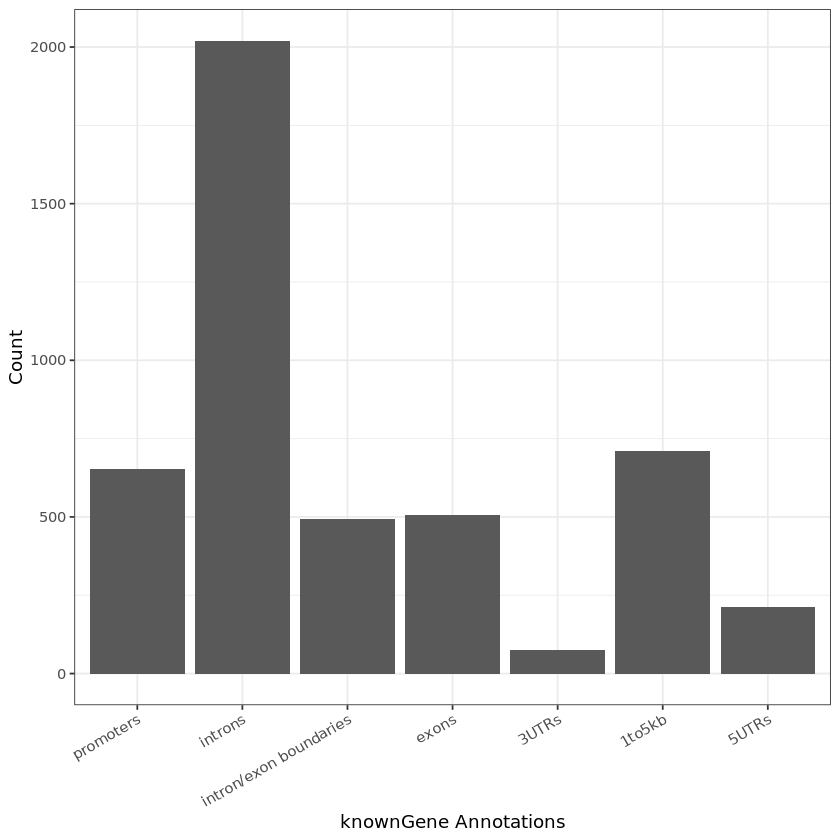

In [14]:
dm_vs_kg_annotations = plot_annotation(
    annotated_regions = df_dm_annotated_ctcf_subset,
    x_label = 'knownGene Annotations',
    y_label = 'Count')
print(dm_vs_kg_annotations)

Warning message:
"`group_by_()` was deprecated in dplyr 0.7.0.
Please use `group_by()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated."


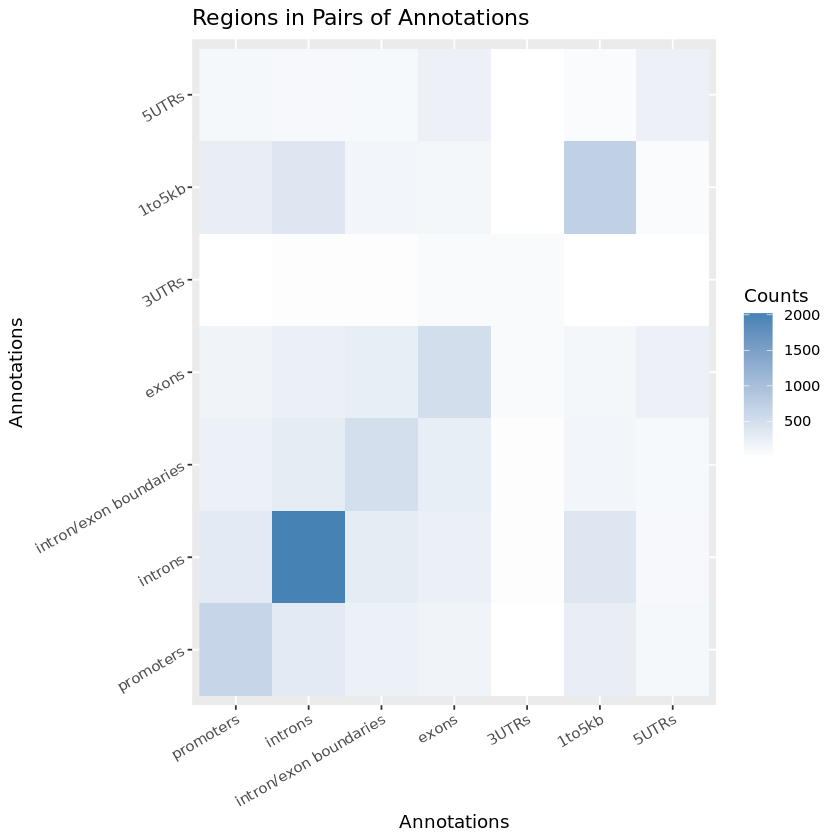

In [15]:
dm_vs_coannotations = plot_coannotations(
    annotated_regions = df_dm_annotated_ctcf_subset,
    quiet=TRUE,
    axes_label = 'Annotations',
    plot_title = 'Regions in Pairs of Annotations')
print(dm_vs_coannotations)

# Karyoplot

In [395]:
# # useMart('http://jan2019.archive.ensembl.org/')
# ensembl <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", host="www.ensembl.org")
# genes <- toGRanges(getBM(attributes=c('chromosome_name', 'start_position', 'end_position', 'hgnc_symbol'),
#                filters = 'hgnc_symbol', values =cvdc, mart = ensembl))
# seqlevelsStyle(genes) <- "UCSC"

# library(TxDb.Hsapiens.UCSC.hg38.knownGene)
# txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
# all.genes <- genes(txdb)

# mcols(consensus_bed_ctcf)$'annot.type' <- df_dm_annotated_ctcf$annot.type

# ranges <- subsetByOverlaps(annotations, consensus_bed_ctcf)
# annos <- annotations[annotations$symbol %in% cvdc,]

In [485]:
cvdc_df <- as.data.frame(cvdc)
cvdc_df[cvdc_df$cvdc %in% c('NADH1', 'AAAS'),]

[1] "AAAS"

In [481]:
# table(df_dm_annotated_ctcf$annot.type)
# table(df_dm_annotated_ctcf_subset$annot.type)
# annotations[annotations$symbol %in% cvdc,]

In [24]:
dm_annotated_ctcf <- as_granges(dm_annotated_ctcf)

In [115]:
# table(dm_annotated_ctcf$annot.type)

In [81]:
dm_annotated_ctcf_ganno_subset <- dm_annotated_ctcf[dm_annotated_ctcf$annot.type == 'hg38_cpg_islands',]

In [100]:
gene_bed <- dm_annotated_ctcf[dm_annotated_ctcf$annot.symbol %in% 
                                               c( 'TMEM143', 'SYNGR4'),]
gene_bed <- gene_bed[gene_bed$annot.type %in% c('hg38_genes_1to5kb')]

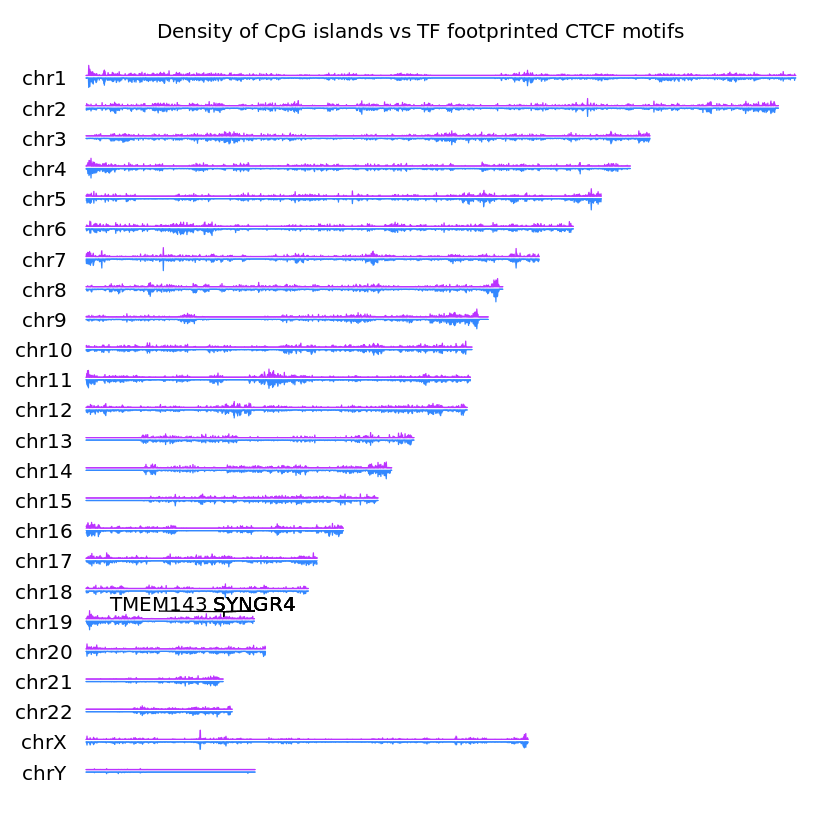

In [118]:
p <- plotKaryotype(plot.type=6,
                    main="Density of CpG islands vs TF footprinted CTCF motifs",
                    ideogram.plotter = NULL,
                   )
kp <- kpPlotDensity(kp,
                    consensus_bed_ctcf , 
                    data.panel="ideogram",
                    col="#3388FF", 
                    border="#3388FF",
                    window.size=100000,
                    r0=0.5, r1=0)



kp <- kpPlotDensity(kp,
                    dm_annotated_ctcf_ganno_subset , 
                    data.panel="ideogram",
                    col="#bb33ff", 
                    border="#bb33ff",
                    window.size=100000,
                    r0=0.6, r1=1)

kpPlotMarkers(kp, 
              data=gene_bed,
              labels=gene_bed$annot.symbol,
              text.orientation = "horizontal",
              r0=0.7,
              cex=1,
              label.dist=0.05, 
              adjust.label.position = TRUE)

In [ ]:
dm_annotated_ctcf_subset <- as_granges(df_dm_annotated_ctcf_subset)
dm_annotated_ctcf_promoters_subset <- dm_annotated_ctcf_subset[dm_annotated_ctcf_subset$annot.type == 'hg38_genes_promoters']

In [74]:
gene_bed <- dm_annotated_ctcf_promoters_subset[dm_annotated_ctcf_promoters_subset$annot.symbol %in% 
                                               c('NOTCH1', 'MYH6','TTN', 'DNAH11', 'DNAI2', 'NPHP3'),]

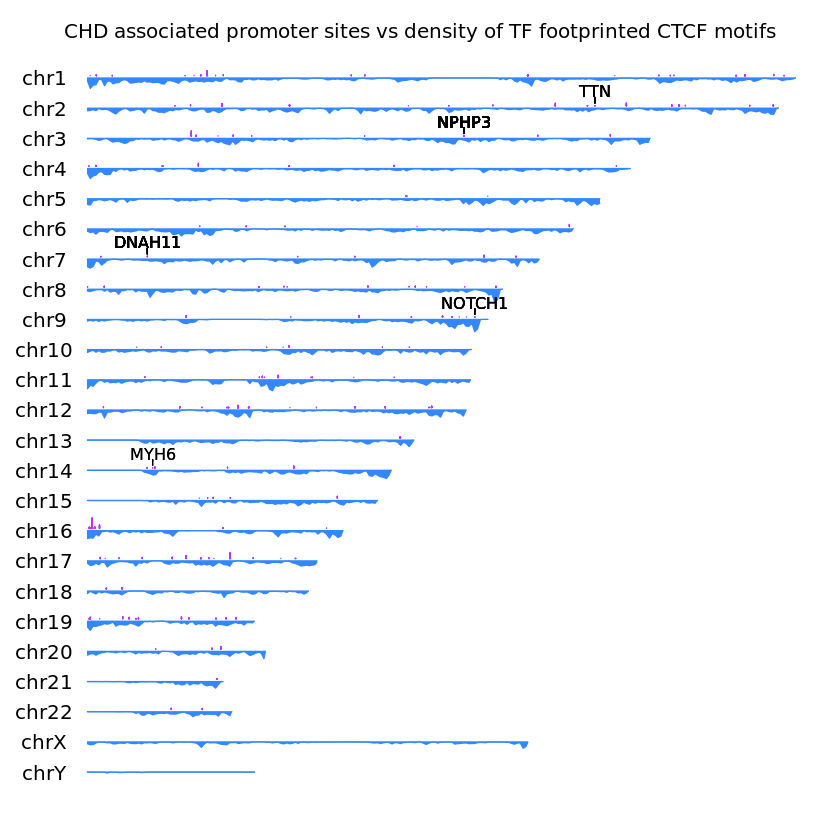

In [77]:
kp <- plotKaryotype(plot.type=6, main="CHD associated promoter sites vs density of TF footprinted CTCF motifs", ideogram.plotter = NULL)
kp <- kpPlotDensity(kp, consensus_bed_ctcf, data.panel="ideogram",
                    col="#3388FF", border="#3388FF", 
                    r0=0.5, r1=0)
kp <- kpPlotRegions(kp, dm_annotated_ctcf_promoters_subset, 
                    data.panel="ideogram", 
                    col="#bb33ff", 
                    border="#bb33ff",
                    r0=0.6, r1=1)
kpPlotMarkers(kp, data=gene_bed, labels=gene_bed$annot.symbol, text.orientation = "horizontal",
              r0=0.7, cex=0.8, adjust.label.position = FALSE)

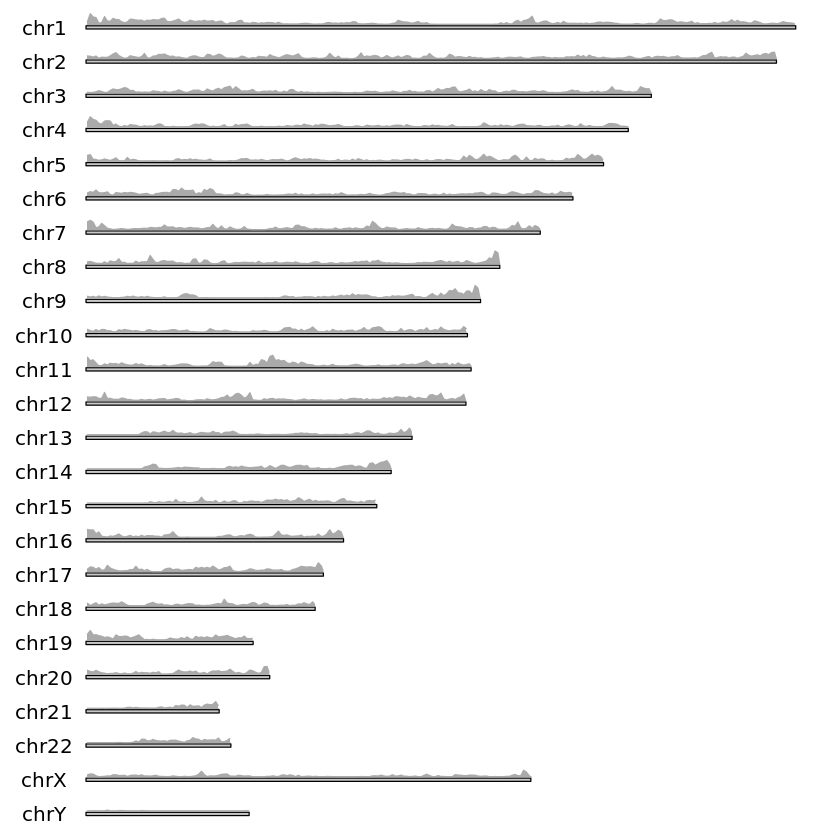

In [298]:
kp <- plotKaryotype(genome="hg38", cytobands = GRanges(), plot.type=2)
kpPlotDensity(kp, data=consensus_bed_ctcf,
              col="#AAAAAA", border="#AAAAAA")

kpPlotDensity(kp, data=cpgs, data.panel=2, col="#AA88FF")


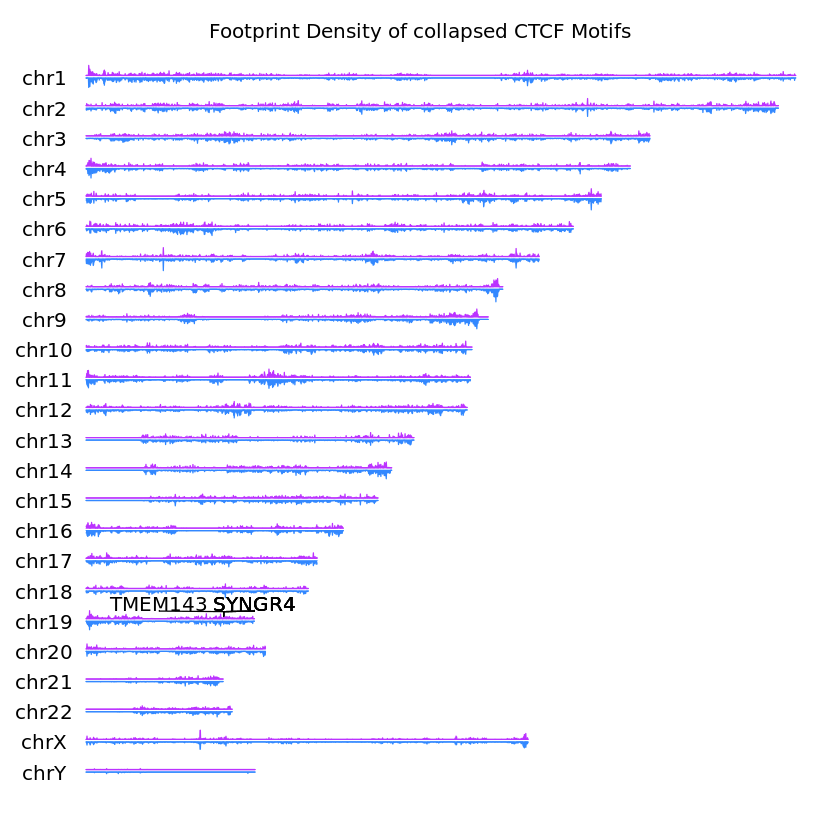

In [108]:
p <- plotKaryotype(plot.type=6,
                    main="Footprint Density of collapsed CTCF Motifs",
                    ideogram.plotter = NULL,
                   )
kp <- kpPlotDensity(kp,consensus_bed_ctcf , 
                    data.panel="ideogram",
                    col="#3388FF", 
                    border="#3388FF",
                    window.size=100000,
                    r0=0.5, r1=0)



kp <- kpPlotDensity(kp,dm_annotated_ctcf_ganno_subset , 
                    data.panel="ideogram",
                    col="#bb33ff", 
                    border="#bb33ff",
                    window.size=100000,
                    r0=0.6, r1=1)
kpPlotMarkers(kp, 
              data=gene_bed,
              labels=gene_bed$annot.symbol,
              text.orientation = "horizontal",
              r0=0.7,
              cex=1,
              label.dist=0.05, 
              adjust.label.position = TRUE)

# EnrichR 

In [418]:
setEnrichrSite("Enrichr") # Human genes

Connection changed to https://maayanlab.cloud/Enrichr/

Connection is Live!



In [433]:
websiteLive <- TRUE

In [438]:
if (websiteLive) {
    enriched <- enrichr(as.vector(cvdc), 'GO_Biological_Process_2021')
}

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


In [457]:
if (websiteLive) enrich_df <- enriched[["GO_Biological_Process_2021"]]

In [459]:
enrich_df[enrich_df$P.value <= 0.05,]

,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,collagen fibril organization (GO:0030199),12/89,2.192815e-09,4.148806e-06,0,0,12.109029,241.43079,COL17A1;COL27A1;COL1A2;COL4A2;COL6A2;COL5A2;COL21A1;COL6A3;COL9A2;COLGALT1;COL19A1;PLEC
2,extracellular matrix organization (GO:0030198),17/300,5.781728e-07,5.469515e-04,0,0,4.711672,67.67560,VIT;COL17A1;COL27A1;VWF;LAMC3;LAMA1;COL19A1;COL1A2;CAPNS1;COL4A2;COL6A2;COL5A2;COL21A1;COL6A3;COL9A2;COLGALT1;PLEC
3,supramolecular fiber organization (GO:0097435),18/351,1.140478e-06,5.727823e-04,0,0,4.245979,58.10224,KRT71;COL17A1;COL27A1;COL19A1;GFAP;CLIP2;COL1A2;COL4A2;MYO1A;MYO15A;COL6A2;COL5A2;COL21A1;COL6A3;COL9A2;COLGALT1;MYH6;PLEC
4,extracellular structure organization (GO:0043062),14/216,1.210956e-06,5.727823e-04,0,0,5.393515,73.48179,VIT;COL17A1;COL27A1;VWF;LAMC3;LAMA1;TEX14;COL19A1;COL1A2;COL4A2;COL6A2;COL5A2;COL6A3;COL9A2
5,calcium ion transport (GO:0006816),10/115,3.094304e-06,1.170884e-03,0,0,7.331466,93.00659,STIM2;ATP2B4;TRPM7;CACNA1S;ATP2C2;CCR5;MICU1;CACNA1H;CACNA1G;TRPM4
6,external encapsulating structure organization (GO:0045229),13/217,6.917828e-06,2.181422e-03,0,0,4.938978,58.68202,VIT;COL17A1;COL27A1;VWF;LAMC3;LAMA1;COL19A1;COL1A2;COL4A2;COL6A2;COL5A2;COL6A3;COL9A2
7,membrane depolarization during AV node cell action potential (GO:0086045),3/5,2.255185e-05,6.095442e-03,0,0,112.975191,1208.79993,SCN5A;CACNA1G;TRPM4
8,mismatch repair (GO:0006298),5/29,3.599521e-05,8.512866e-03,0,0,15.794071,161.60690,MSH6;MLH1;PMS1;MLH3;TP73
9,AV node cell action potential (GO:0086016),3/7,7.739113e-05,1.626934e-02,0,0,56.481870,534.69344,SCN5A;CACNA1G;TRPM4


# Consensus Analysis

In [72]:
consensus.analysis <- function(bed_list,
                               map_bed,
                               consensus_bed){
    
    print(paste('Number of regions in mappable regions: ', nrow(toDataframe(map_bed)), 
                sep=' '))
    
    cat('\n')

    print(paste('Number of regions in the consensus: ', nrow(toDataframe(consensus_bed)), 
                sep=' '))
    
    cat('\n')

    
    # number of regions in dataset of interest
    for (bed_df in names(bed_list)) {
        print(paste(bed_df, 'number of regions:', nrow(toDataframe(bed_list[[bed_df]])), sep=' '))
    }
    
    cat('\n')
    
    # check if the dataset of interest is a proper subset of mappable regions
        for (bed_df in names(bed_list)) {
            print(bed_df)
            print(paste('Number of overlaps in mappable regions:',
                        numOverlaps(bed_list[[bed_df]], 
                                    map_bed, 
                                    count.once=TRUE), sep=' '))
            print(paste('Number of overlaps in consensus:', 
                        numOverlaps(bed_list[[bed_df]], 
                                    consensus_bed, 
                                    count.once=TRUE), sep=' '))
            cat('\n')

        }
    
}

# consensus.analysis(cd20_beds, map_bed, consensus_bed)
# Subset cd20+ bcells to Chr19
for (bed_df in names(cd20_beds)) {
    cd20_beds[[bed_df]] <- cd20_beds[[bed_df]][cd20_beds[[bed_df]]@seqnames == "chr19"]
}
consensus.analysis(cd20_beds, map_bed_chr19, consensus_bed_chr19) # cd20_beds filtered to chr19

# Export chr19 subset data
# write.table(map_bed_chr19, "/home/jupyter/human-TF-footprinting/Data/mappability.stranded.hg38.chr19.bed", append = TRUE, sep = "")
# write.table(consensus_bed_chr19, "/home/jupyter/human-TF-footprinting/Data/consensus_footprints_and_collapsed_motifs_hg38_chr19.bed", append = TRUE, sep = "")
# write.table(cd20_all_chr19, "/home/jupyter/human-TF-footprinting/Data/interval.all.chr19.bed", append = TRUE, sep = "")

[1] "Number of regions in mappable regions:  1833378"

[1] "Number of regions in the consensus:  126666"

[1] "cd20_0.0001 number of regions: 9661"
[1] "cd20_0.001 number of regions: 14646"
[1] "cd20_0.01 number of regions: 28221"
[1] "cd20_0.05 number of regions: 50162"

[1] "cd20_0.0001"
[1] "Number of overlaps in mappable regions: 9554"
[1] "Number of overlaps in consensus: 9146"

[1] "cd20_0.001"
[1] "Number of overlaps in mappable regions: 14479"
[1] "Number of overlaps in consensus: 13126"

[1] "cd20_0.01"
[1] "Number of overlaps in mappable regions: 27879"
[1] "Number of overlaps in consensus: 21812"

[1] "cd20_0.05"
[1] "Number of overlaps in mappable regions: 49551"
[1] "Number of overlaps in consensus: 32613"



In [9]:
avg_numsamples_per_chr.names <- unlist(unique(consensus_bed@seqnames))
avg_numsamples_per_chr <- rep(NA, length(avg_numsamples_per_chr.names))
names(avg_numsamples_per_chr) <- avg_numsamples_per_chr.names
for (chr in unique(consensus_bed@seqnames)){
    avg_numsamples_per_chr[[chr]] <- mean(consensus_bed[consensus_bed@seqnames == chr]$V6)
}
avg_numsamples_per_chr_df <- data.frame(avg_numsamples_per_chr)

In [11]:
avg_numsamples_per_chr_df

,avg_numsamples_per_chr
,<dbl>
chr1,11.598195
chr10,9.776064
chr11,11.466149
chr12,11.159547
chr13,8.410232
chr14,10.931864
chr15,10.934215
chr16,12.371862
chr17,13.943751


# Boxplot Analysis

In [109]:
dhs.boxplot <- function(boxplot_df,
                       title,
                       x_label,
                       y_label){
    ggplot(boxplot_df, aes(x=X, y=Y)) +
    geom_boxplot(outlier.shape = NA) + coord_cartesian(ylim = quantile(boxplot_df$Y, c(0.01, .94))) +
    theme(axis.text.x=element_text(angle=45,margin = margin(1, unit = "cm"),vjust =1)) + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.background = element_blank(), axis.line = element_line(colour = "black")) + 
    labs(title=title,
         x=x_label,
         y=y_label)
}

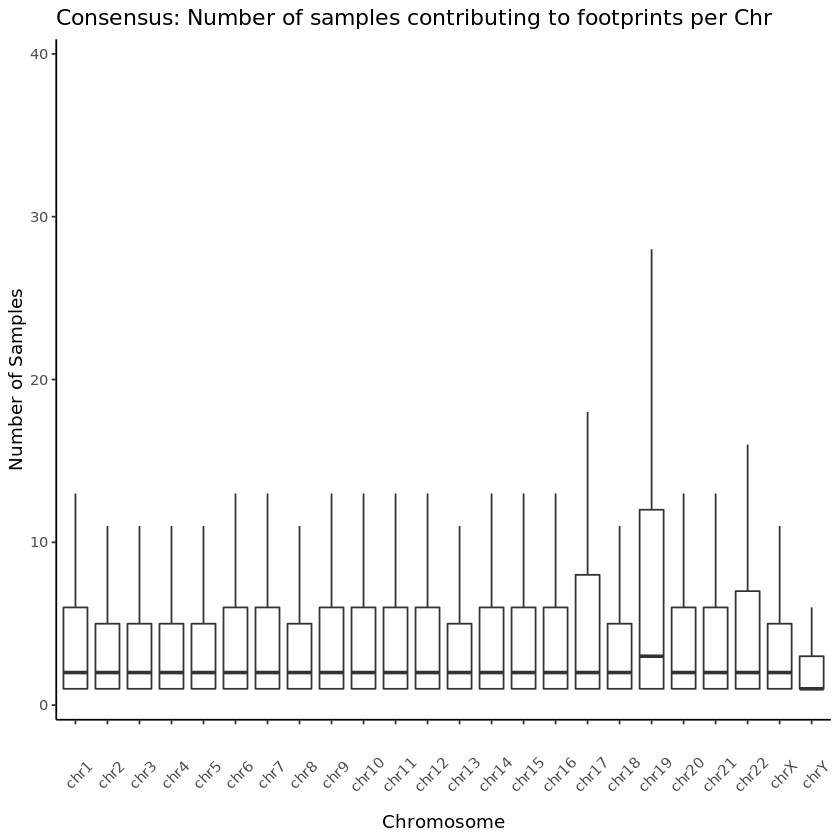

In [19]:
consensus_boxplot_df <- data.frame(X=consensus_bed@seqnames,Y=consensus_bed$V6)
rename.chr <- paste(rep('chr',24),seq(1, 24, by=1),sep='')
rename.chr[[24]] <- 'chrY'
rename.chr[[23]] <- 'chrX'
consensus_boxplot_df$X <- factor(consensus_boxplot_df$X, levels=rename.chr)

dhs.boxplot(consensus_boxplot_df,
           "Consensus: Number of samples contributing to footprints per Chr",
           "Chromosome",
           "Number of Samples")

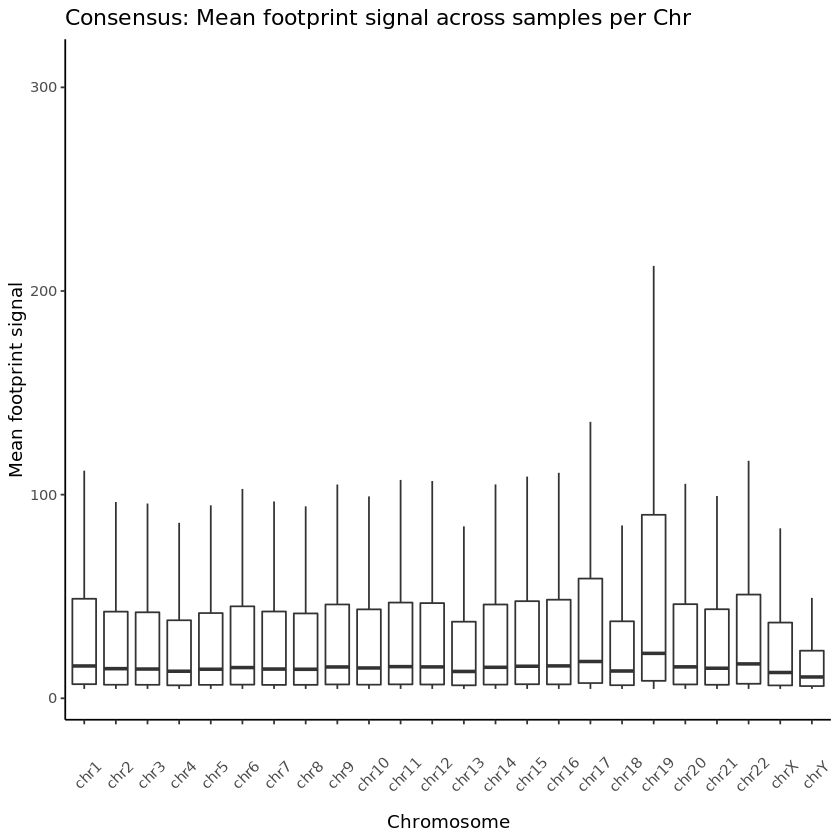

In [20]:
consensus_boxplot_df <- data.frame(X=consensus_bed@seqnames,Y=consensus_bed$V5)
rename.chr <- paste(rep('chr',24),seq(1, 24, by=1),sep='')
rename.chr[[24]] <- 'chrY'
rename.chr[[23]] <- 'chrX'
consensus_boxplot_df$X <- factor(consensus_boxplot_df$X, levels=rename.chr)

dhs.boxplot(consensus_boxplot_df,
           "Consensus: Mean footprint signal across samples per Chr",
           "Chromosome",
           "Mean footprint signal")

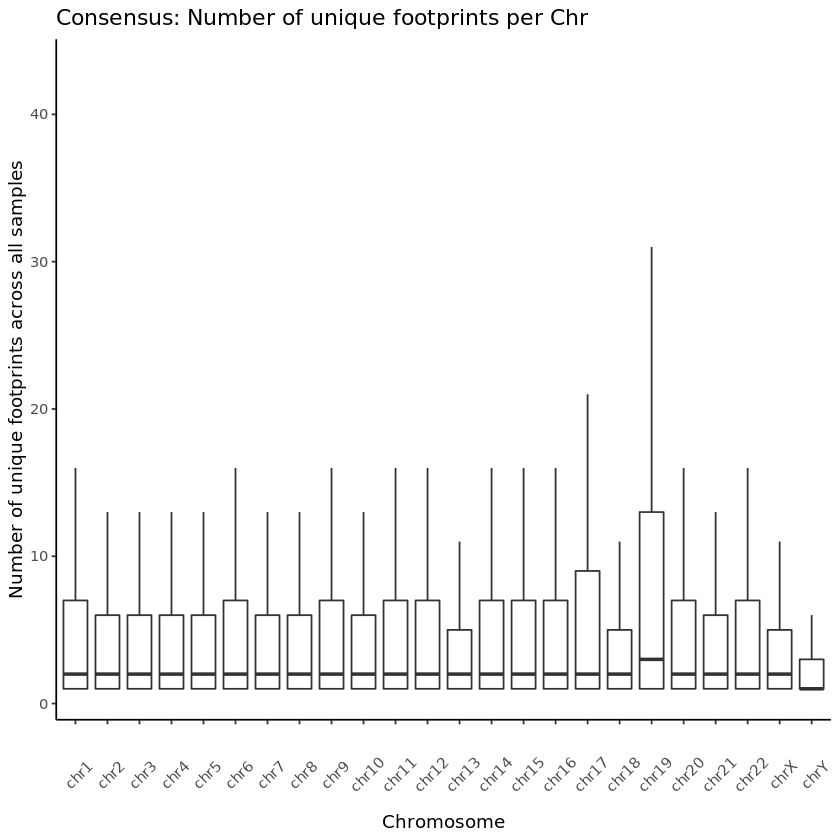

In [110]:
consensus_boxplot_df <- data.frame(X=consensus_bed@seqnames,Y=consensus_bed$V7)
rename.chr <- paste(rep('chr',24),seq(1, 24, by=1),sep='')
rename.chr[[24]] <- 'chrY'
rename.chr[[23]] <- 'chrX'
consensus_boxplot_df$X <- factor(consensus_boxplot_df$X, levels=rename.chr)


dhs.boxplot(consensus_boxplot_df,
           "Consensus: Number of unique footprints per Chr",
           "Chromosome",
           "Number of unique footprints across all samples")


In [48]:
count_footprint_per_chr.names <- unlist(unique(cd20_beds[['cd20_0.0001']]@seqnames))
count_footprint_per_chr <- rep(NA, length(count_footprint_per_chr.names))
names(count_footprint_per_chr) <- count_footprint_per_chr.names

for (chr in unique(cd20_beds[['cd20_0.0001']]@seqnames)){
    count_footprint_per_chr[chr] <- nrow(toDataframe(cd20_beds[['cd20_0.0001']][cd20_beds[['cd20_0.0001']]@seqnames == chr]))
}
count_footprint_per_chr_df <- data.frame(count_footprint_per_chr)

rename.chr <- paste(rep('chr',24),seq(1, 24, by=1),sep='')
rename.chr[[24]] <- 'chrY'
rename.chr[[23]] <- 'chrX'
count_footprint_per_chr_df$chr <- row.names(count_footprint_per_chr_df)
count_footprint_per_chr_df$chr <- factor(count_footprint_per_chr_df$chr, levels=rename.chr)

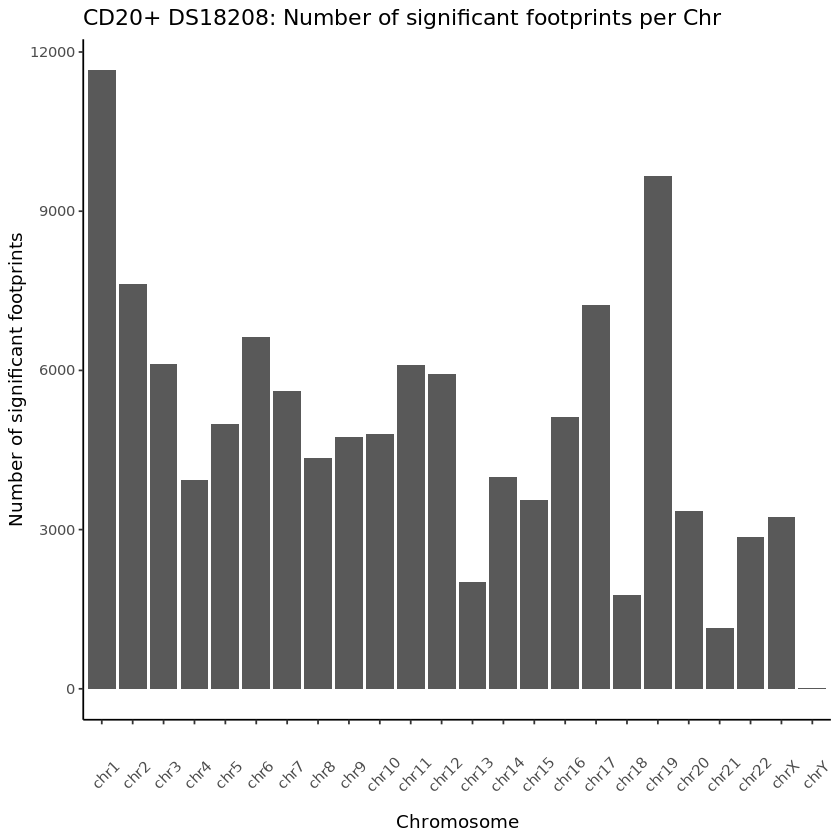

In [63]:
ggplot(data=count_footprint_per_chr_df, aes(x=chr, y=count_footprint_per_chr)) +
  geom_bar(stat="identity") +
    theme(axis.text.x=element_text(angle=45,margin = margin(1, unit = "cm"),vjust =1)) + 
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      panel.background = element_blank(), axis.line = element_line(colour = "black"))+ 
    labs(title='CD20+ DS18208: Number of significant footprints per Chr',
         x='Chromosome',
         y='Number of significant footprints')

# CpG Analysis

In [53]:
HeatedDensityPlot <- function(x,
                              title = "",
                              x.title = "x",
                              colors = c('#d7191c','#fdae61','#ffffbf','#abdda4','#2b83ba'),
                              show.legend = TRUE, 
                              legend.title = "Cumulative %", 
                              n = 512, # Number of unique values of x in the heatmap/density estimation
                              n.breaks = 5, # Number of values of x to show on the x-axis. Final number may differ.
                              ...)
{
    # Checking inputs.
    n.obs <- length(x)
    if (any(nas <- is.na(x))) {
        warning(sum(nas), " observations with missing values have been removed.")
        x <- x[!nas]
        n.obs <- length(x)
    }
    if (n.obs < 4)
        stop(n.obs, " is too few observations for a valid density plot. See Silverman (1986) Density Estimation for Statistics and Data Analysis.")
    # Computing densities
    dens <- density(x, ...)
    y.max <- max(dens$y) * 1.1 # To ensure top of plot isn't too close to title
    x.to.plot.true <- x.to.plot <- dens$x
    y.seq <- c(0, y.max/2, y.max)
    y.to.plot <- dens$y
    range.x = range(x)
    cum.dens <- ecdf(x)(x.to.plot)# * 100
    #Due to plotly blug that misaligns heatmap with ensuing white line,
    #putting blanks at beginnig of data.
    n.blanks <- 10
    cum.dens <- c(rep(NA, n.blanks), cum.dens)
    diff <- x.to.plot[1] - x.to.plot[2]
    blanks <- diff * (n.blanks:1) + x.to.plot[1]
    x.to.plot <- c(blanks, x.to.plot)
    y.to.plot <- c(rep(0, n.blanks), y.to.plot)
    # Creating the matrix of heatmap values
    cum.perc <- cum.dens * 100
    z.mat <- matrix(cum.perc, byrow = TRUE, nrow = 3, ncol = n + n.blanks,
                    dimnames = list(y = y.seq, x = x.to.plot))
    # Specifying the colors
    col.fun <- scales::col_numeric(colors, domain = 0:1, na.color = "white")#range.x)
    x.as.colors <- col.fun(cum.dens)
    z.to.plot.scaled <- scales::rescale(cum.perc)
    color.lookup <- setNames(data.frame(z.to.plot.scaled, x.as.colors), NULL)
    # Creating the base heatmap.
    require(plotly)
    p <- plot_ly(z = z.mat,
                 xsrc = x.to.plot,
                 ysrc = y.seq,
                 type = "heatmap",
                 colorscale = color.lookup,
                 cauto = FALSE,
                 hoverinfo = "none",
                  colorbar = list(title = legend.title),
                 showscale = show.legend)
    # Placing white on top of the bits of the heatmap to hide
    p <- add_trace(p,
                   x = c(1:(n + n.blanks), (n + n.blanks):1),
                   y = c(y.to.plot, rep(y.max * 1.10, n + n.blanks)),
                   fill = "tonexty",
                   hoverinfo = "none",
                   showlegend = FALSE,
                   type = "scatter",
                   mode = "line",
                   showscale = FALSE, 
                   line = list(color = "white", width = 0),
                   fillcolor = "white")
    # Adding the tooltips
    p <- add_trace(p,
                   x = 1:(n + n.blanks),
                   y = y.to.plot,
                   name = "",
                   hoverinfo = "text",
                   text = sprintf(paste0(x.title,": %.0f %% < %.1f"), cum.perc, x.to.plot),
                   type = "scatter",
                   mode = "lines",
                   line = list(color = "white", width = 0),
                   showlegend=FALSE, 
                   showscale=FALSE)
    p <- plotly::config(p, displayModeBar = FALSE)
    # Formatting the x axis
    x.text <- pretty(x.to.plot, n = n.breaks)
    x.tick <- 1 + (x.text - x.to.plot[1]) / (x.to.plot[n + n.blanks] - x.to.plot[1]) * (n + n.blanks - 1)
    p <- layout(p, title = title,
                xaxis = list(title = x.title, tickmode = "array", tickvals = x.tick, ticktext = x.text),
                yaxis = list(title = "", showline = FALSE, ticks = "", showticklabels = FALSE, range= c(0, y.max)),
                margin = list(t = 30, l = 5, b = 50, r = 5))
    p
}

In [29]:
annotations = build_annotations(genome = 'hg38', annotations = c('hg38_cpgs'))

Building CpG islands...

Building CpG shores...

Building CpG shelves...

Building inter-CpG-islands...



In [24]:
# subset to genomic interval of interest
genomic_interval_sub <- GRanges(seqnames="chr19",
          ranges=IRanges(start = 48363826, end = 48364602)) # start - 48364000 end - 48364600

consensus_sub <- subsetByOverlaps(consensus_bed_chr19, genomic_interval_sub)
cd20_sub <- subsetByOverlaps(cd20_beds[['cd20_0.0001']], genomic_interval_sub)
cd20_all <- subsetByOverlaps(cd20_all_chr19, genomic_interval_sub)
cd20_all <- cd20_all[cd20_all$V8 <= 0.05]

In [31]:
# nrow(toDataframe(consensus_sub))
# nrow(toDataframe(cd20_sub))
# numOverlaps(cd20_sub, consensus_sub, count.once=TRUE)
# numOverlaps(consensus_sub, cd20_sub, count.once=TRUE)

In [48]:
cd20_all_df <- toDataframe(cd20_all)

In [54]:
head(cd20_all_df)

,chr,start,end,V4,V5,V6,V7,V8
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
146,chr1,180850,180851,0,0,0.1707,0.1388,0.0045
147,chr1,180851,180852,0,0,0.1707,0.1388,0.0045
148,chr1,180852,180853,1,0,1.0108,0.1388,0.0045
149,chr1,180853,180854,1,0,1.0108,0.1388,0.0045
150,chr1,180854,180855,0,0,0.1707,0.1388,0.0045
151,chr1,180855,180856,1,0,1.0108,0.3133,0.0002


In [ ]:
plot = ggplot(cd20_all_df, aes(x=start, y=V4)) # , fill=V8
plot + geom_area()

Annotating...



# A tibble: 4 × 2
  annot.type           n
  <chr>            <int>
1 hg38_cpg_inter   59852
2 hg38_cpg_islands 23823
3 hg38_cpg_shelves 12626
4 hg38_cpg_shores  31780


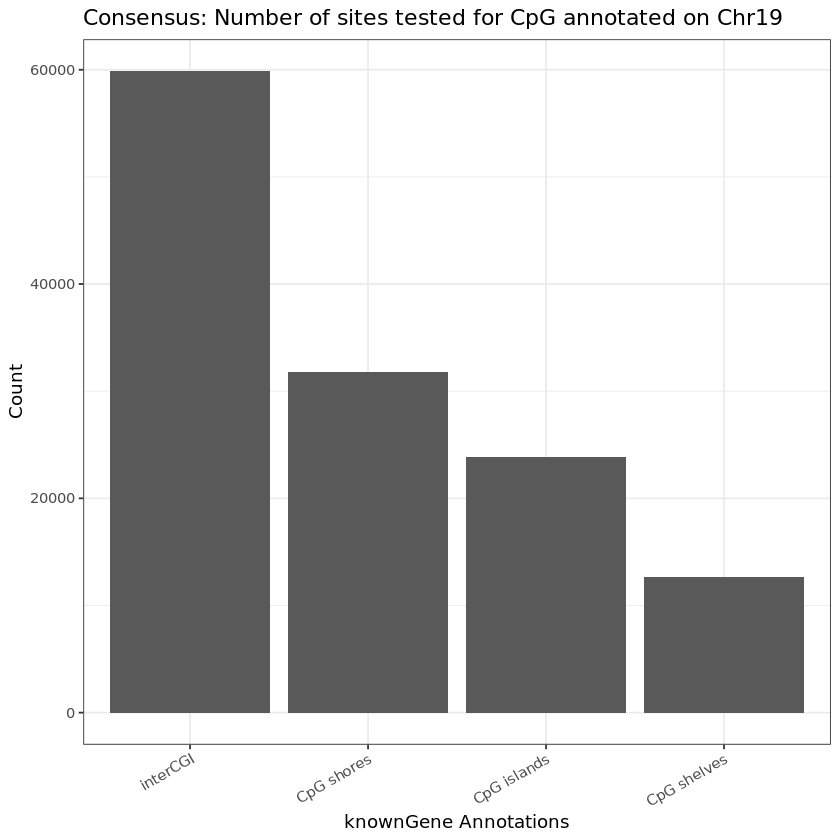

In [116]:
dm_annotated = annotate_regions(
    regions = consensus_bed_chr19,
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = FALSE)

df_dm_annotated = data.frame(dm_annotated)
# print(head(df_dm_annotated))

dm_annsum = summarize_annotations(
    annotated_regions = dm_annotated,
    quiet = TRUE)
print(dm_annsum)

 plot_annotation(
    annotated_regions = dm_annotated,
     annotation_order = c('hg38_cpg_inter','hg38_cpg_shores','hg38_cpg_islands','hg38_cpg_shelves'),

    plot_title = 'Consensus: Number of sites tested for CpG annotated on Chr19',
    x_label = 'knownGene Annotations',
    y_label = 'Count')

# summarize_numerical(
#     annotated_regions = dm_annotated,
#     by = c('annot.type', 'annot.id'),
#     over = c('hg38_cpg_inter','hg38_cpg_islands','hg38_cpg_shelves','hg38_cpg_shores'),
#     quiet = TRUE)


Annotating...



# A tibble: 4 × 2
  annot.type           n
  <chr>            <int>
1 hg38_cpg_inter    2136
2 hg38_cpg_islands  5194
3 hg38_cpg_shelves   521
4 hg38_cpg_shores   1979


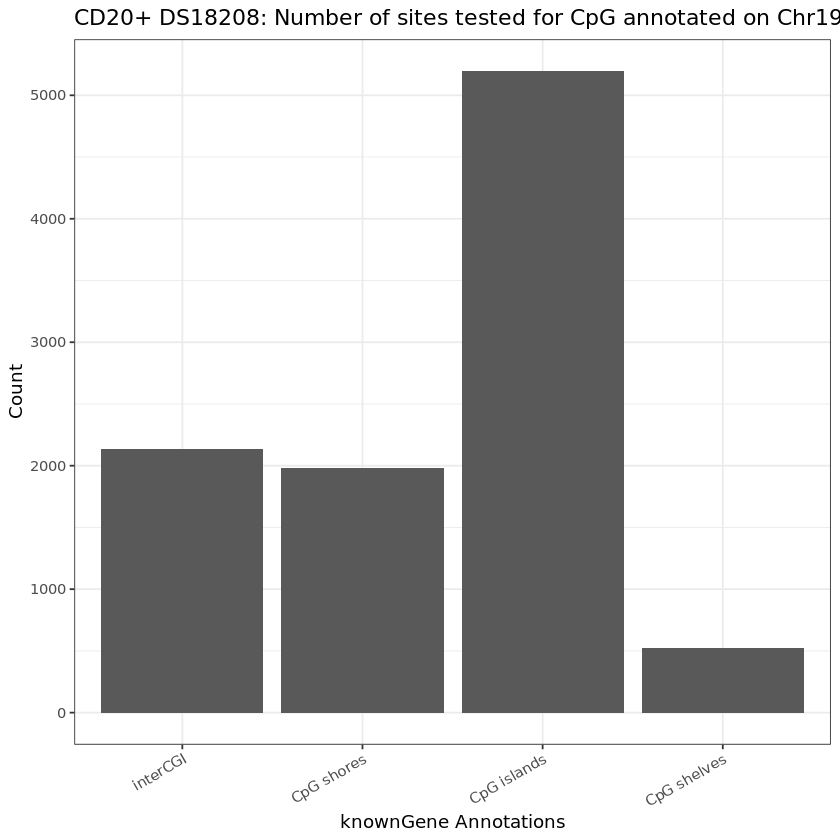

In [165]:
dm_annotated = annotate_regions(
    regions = cd20_beds[['cd20_0.0001']],
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = FALSE)

df_dm_annotated = data.frame(dm_annotated)
# print(head(df_dm_annotated))

dm_annsum = summarize_annotations(
    annotated_regions = dm_annotated,
    quiet = TRUE)
print(dm_annsum)

 plot_annotation(
    annotated_regions = dm_annotated,
     annotation_order = c('hg38_cpg_inter','hg38_cpg_shores','hg38_cpg_islands','hg38_cpg_shelves'),
    plot_title = 'CD20+ DS18208: Number of sites tested for CpG annotated on Chr19',
    x_label = 'knownGene Annotations',
    y_label = 'Count')


Annotating...



  seqnames    start      end width strand V4    V5 annot.seqnames annot.start
1    chr19 48363983 48364005    23      *  . 1e-04          chr19    48363931
2    chr19 48364033 48364045    13      *  . 1e-04          chr19    48363931
3    chr19 48364048 48364071    24      *  . 1e-04          chr19    48363931
4    chr19 48364093 48364116    24      *  . 1e-04          chr19    48363931
5    chr19 48364118 48364127    10      *  . 1e-04          chr19    48363931
6    chr19 48364142 48364156    15      *  . 1e-04          chr19    48363931
  annot.end annot.width annot.strand     annot.id annot.tx_id annot.gene_id
1  48364350         420            * island:14832          NA            NA
2  48364350         420            * island:14832          NA            NA
3  48364350         420            * island:14832          NA            NA
4  48364350         420            * island:14832          NA            NA
5  48364350         420            * island:14832          NA            N

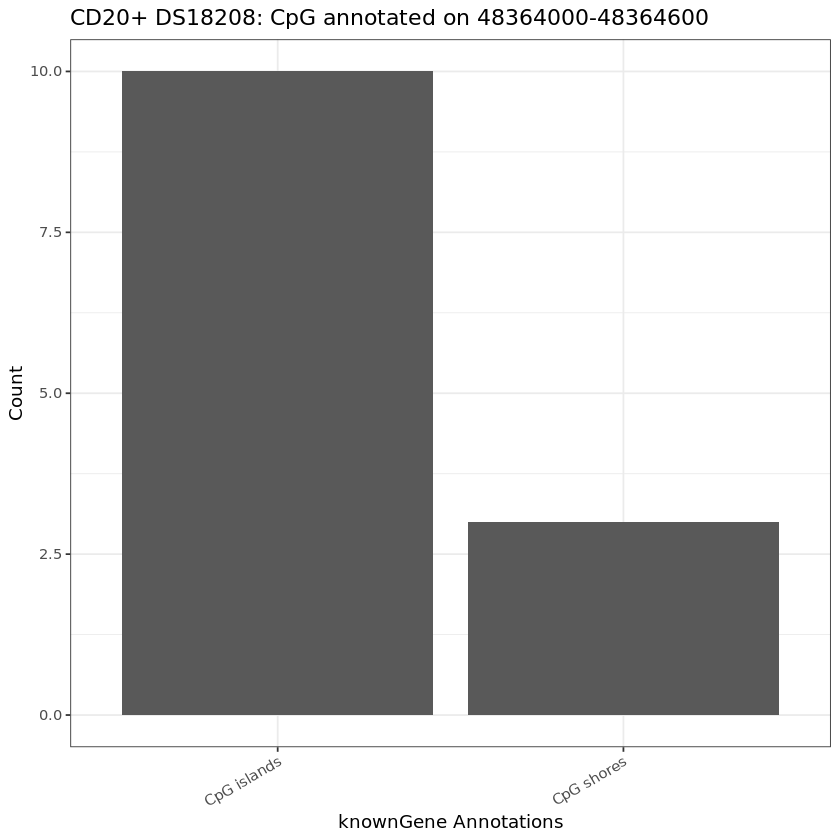

In [136]:
q=GRanges(seqnames="chr19",
          ranges=IRanges(start = 48364000, end = 48364600))
demo <- subsetByOverlaps(cd20_beds[['cd20_0.0001']], q)

dm_annotated = annotate_regions(
    regions = demo,
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = FALSE)

df_dm_annotated = data.frame(dm_annotated)
print(head(df_dm_annotated))

dm_annsum = summarize_annotations(
    annotated_regions = dm_annotated,
    quiet = TRUE)
print(dm_annsum)

 plot_annotation(
    annotated_regions = dm_annotated,
    plot_title = 'CD20+ DS18208: CpG annotated on 48364000-48364600',
    x_label = 'knownGene Annotations',
    y_label = 'Count')

In [121]:
map_test <- read_regions('/home/jupyter/human-TF-footprinting/Data/mappability.stranded.hg38.bed')

In [123]:
map_bed_chr19 <- map_bed[map_bed@seqnames == 'chr19']

Given a set of annotated regions, it is important to know how the annotations compare to those of a randomized set of regions. The randomize_regions() function is a wrapper of regioneR::randomizeRegions() from the regioneR package that creates a set of random regions given a GRanges object. After creating the random set, they must be annotated with annotate_regions() for later use. Only builtin_genomes() can be used in our wrapper function. Downstream functions that support using random region annotations are summarize_annotations(), plot_annotation(), and plot_categorical().

It is important to note that if the regions to be randomized have a particular property, for example they are CpGs, the randomize_regions() wrapper will not preserve that property! Instead, we recommend using regioneR::resampleRegions() with universe being the superset of the data regions you want to sample from.

In [22]:
q=GRanges(seqnames="chr19",
          ranges=IRanges(start = 48364000, end = 48364600))
cd20_chr19_subset <- subsetByOverlaps(cd20_beds[['cd20_0.0001']], q)
consensus_bed_chr19_subset <- subsetByOverlaps(consensus_bed_chr19, q)
map_bed_chr19_subset <- subsetByOverlaps(map_bed_chr19, q)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'subsetByOverlaps': object 'map_bed_chr19' not found


In [155]:
numOverlaps(cd20_chr19_subset, map_bed_chr19_subset, count.once=TRUE)
numOverlaps(consensus_bed_chr19_subset, map_bed_chr19_subset, count.once=TRUE)

[1] 12

[1] 16

In [164]:
boot_test <- permTest(A=consensus_bed_chr19_subset, B=map_bed_chr19_subset,
                ntimes=10,
                randomize.function=resampleRegions,
                universe=map_bed_chr19_subset,
                replace=TRUE,
                evaluate.function=numOverlaps)

[1] "Note: The minimum p-value with only 10 permutations is 0.0909090909090909. You should consider increasing the number of permutations."


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'i' in selecting a method for function '[': cannot take a sample larger than the population when 'replace = FALSE'


In [139]:
# mask <- subtractRegions('hg38', map_bed_chr19)


# new.regions <- createRandomRegions(nregions = num.regions, length.mean = region.length,
#                                    length.sd = 0, genome = genome, mask = mask,
#                                    non.overlapping = TRUE)

In [129]:
# Randomize the input regions
dm_random_regions = randomize_regions(
    regions = map_bed_chr19,
    allow.overlaps = TRUE,
    per.chromosome = TRUE)

In [ ]:
# Annotate the random regions using the same annotations as above
# These will be used in later functions
dm_random_annotated = annotate_regions(
    regions = dm_random_regions,
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = TRUE)

In [8]:
a <- data.frame("length" = c(width(cd20_beds[['cd20_0.0001']]), width(consensus_bed_chr19)),
                 "group" = c(rep("cd20_0.0001", length(cd20_beds[['cd20_0.0001']])),
                             rep("consensus", length(consensus_bed_chr19)))
)

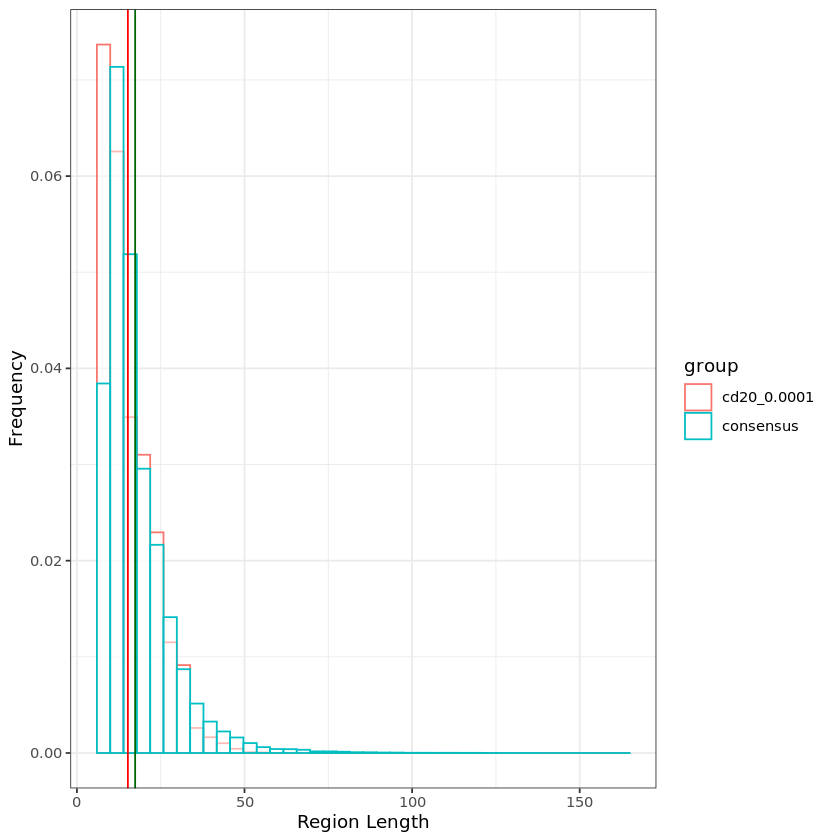

In [11]:
 ggplot(a, aes(x=length, color=group)) +
   geom_histogram(aes(y=..density..), fill="white", alpha=0.5, position="identity", bins = 40) +
   theme_bw() +
   geom_vline(xintercept = mean(a[a$group == "cd20_0.0001", "length"]), color="red") +
   geom_vline(xintercept = mean(a[a$group == "consensus", "length"]), color="darkgreen") +
   xlab("Region Length") + ylab("Frequency")

In [128]:
# consensus_bed_chr19[consensus_bed_chr19$V5==max(consensus_bed_chr19$V5)]

In [56]:
# consensus_bed_chr19[seqnames(consensus_bed_chr19) == "chr19"
#                     & start(consensus_bed_chr19) > 48364000 & end(consensus_bed_chr19) < 48364600] 

In [57]:
# barplot(consensus_bed_chr19$V5)

In [71]:
# consensus_bed_chr19_subset <- consensus_bed_chr19[consensus_bed_chr19$V6>=20]
# summary(glm(chr ~ num_fps, family=poisson, data=consensus_glm_df))

In [59]:
consensus_boxplot_df <- data.frame(chr=consensus_bed@seqnames,
                               num_fps=consensus_bed$V7,
                               width=consensus_bed$V8)

pairwise.wilcox.test(consensus_boxplot_df$Y, 
                     consensus_boxplot_df$X,
                     p.adjust.method="bonf")


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  consensus_boxplot_df$Y and consensus_boxplot_df$X 

      chr1    chr10   chr11   chr12   chr13   chr14   chr15   chr16   chr17  
chr10 < 2e-16 -       -       -       -       -       -       -       -      
chr11 0.00011 < 2e-16 -       -       -       -       -       -       -      
chr12 1.7e-05 < 2e-16 1.00000 -       -       -       -       -       -      
chr13 < 2e-16 < 2e-16 < 2e-16 < 2e-16 -       -       -       -       -      
chr14 6.5e-10 6.2e-06 1.00000 1.00000 < 2e-16 -       -       -       -      
chr15 0.74655 < 2e-16 1.00000 1.00000 < 2e-16 0.22371 -       -       -      
chr16 1.00000 < 2e-16 0.02457 0.00836 < 2e-16 2.6e-06 1.00000 -       -      
chr17 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 -      
chr18 < 2e-16 < 2e-16 < 2e-16 < 2e-16 1.00000 < 2e-16 < 2e-16 < 2e-16 < 2e-16
chr19 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16
ch

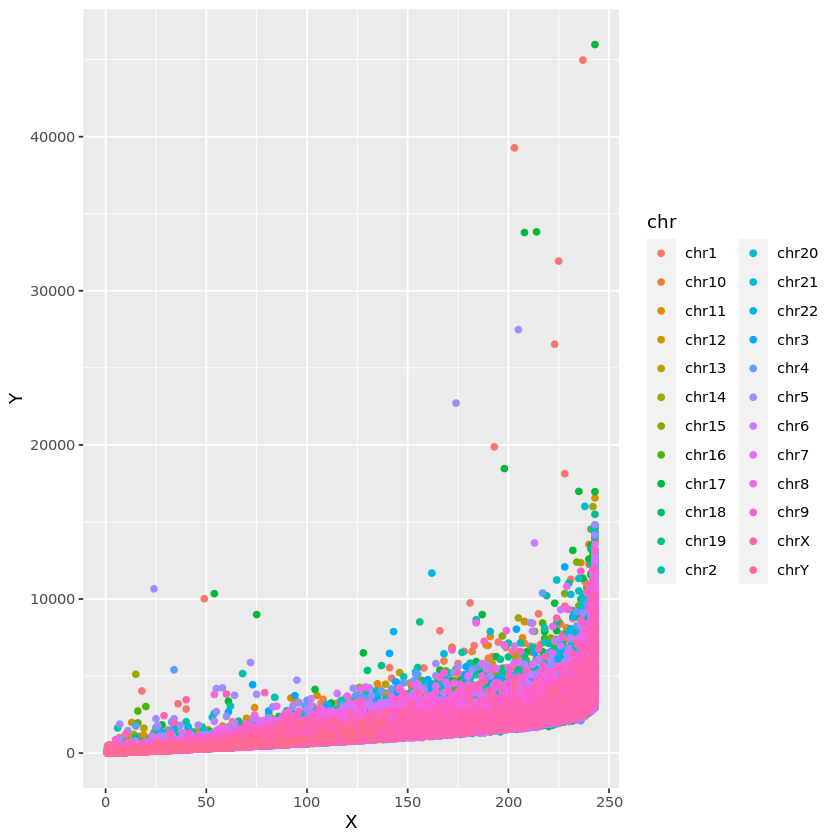

In [48]:
q=GRanges(seqnames="chr19",
          ranges=IRanges(start = 48364000, end = 48364600))

demo <- subsetByOverlaps(consensus_bed_chr19_motifs, q)

consensus_plot_df <- data.frame(X=demo$V6, Y=demo$V5)
# consensus_plot_df <- data.frame(X=consensus_bed$V6, Y=consensus_bed$V5, chr=consensus_bed@seqnames)

ggplot(data=consensus_plot_df, aes(x=X, y=Y, color=chr)) + geom_point()

# Line plot
# ggplot(data=consensus_plot_df, aes(x=X, y=Y, group=chr)) +
#   geom_line(color="red")+
#   geom_point()

In [130]:
# consensus_bed_chr19_motifs <- consensus_bed_chr19[!(consensus_bed_chr19$V12==""), ]